In [30]:
import networkx  as nx
import numpy as np
import matplotlib.pyplot as plt

from patrolling.agents import AgentType
from patrolling.elevation_map import load_heightmapgrid_from_bag, visualize_elevationmap
from patrolling.graph import load_graph_from_npz, shift_scale_graph

# Load the graphs and visualize them with the height map

In [31]:
origin_resolution = np.load('assets/cde-b-assets/polypixel.heightmap.origin-resolution.npz')
background_grey = plt.imread('assets/cde-b-assets/polypixel.heightmap.greyscale.png')

origin = origin_resolution['origin']
resolution = origin_resolution['resolution']

ground_graph_unscaled = load_graph_from_npz('assets/cde-b-assets/polypixel_ground_graph_metric.npz')
quad_graph_unscaled = load_graph_from_npz('assets/cde-b-assets/polypixel_quad_graph_metric.npz')

In [32]:
ground_graph = shift_scale_graph(ground_graph_unscaled, origin, resolution)
quad_graph = shift_scale_graph(quad_graph_unscaled, origin, resolution)

# Load the elevation map

In [5]:
height_map = load_heightmapgrid_from_bag('assets/cde-b-assets/polypixel.heightmap.bag')

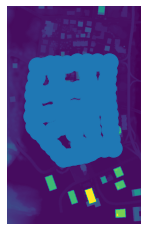

In [8]:
fig, ax = plt.subplots(1, 1)
pos = dict([(v, v) for v in ground_graph.nodes])
nx.draw(ground_graph, ax=ax, pos=pos)
ax.imshow(height_map, extent=(0, height_map.shape[1], 0, height_map.shape[0]))

# Load visibility info
## Load global visibility

In [9]:
ground_vis_scores_unnorm = np.load('assets/cde-b-assets/pp_ground_global_vis.npy')
quad_vis_scores_unnorm = np.load('assets/cde-b-assets/pp_quad_global_vis.npy')

max_vis_ground = np.max(ground_vis_scores_unnorm)
max_vis_quad = np.max(quad_vis_scores_unnorm)
max_vis_score = max(max_vis_ground, max_vis_quad)

ground_vis_scores = ground_vis_scores_unnorm / max_vis_score
quad_vis_scores = quad_vis_scores_unnorm / max_vis_score

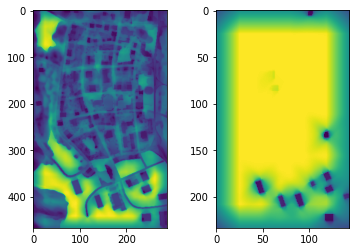

In [10]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(ground_vis_scores)
axes[1].imshow(quad_vis_scores)

## TODO: Build the visibility dictionaries

In [11]:
def build_vis_dict_from_vis_map():
    pass

##  Load  pointwise  visibility

In [12]:
pointwise_vis = np.load('assets/cde-b-assets/pointwise_vis.npz')

In [62]:
vis_graphs = dict()

for agent_type1 in AgentType:
    vis_graphs[agent_type1] = dict()
    for agent_type2 in AgentType:
        if (agent_type1, agent_type2) == (AgentType.QUAD, AgentType.QUAD):
            vis_graph = build_vis_graph(quad_graph, pointwise_vis['ava'])
        elif (agent_type1, agent_type2) == (AgentType.QUAD, AgentType.GROUND):
            vis_graph = build_vis_graph(quad_graph, pointwise_vis['avg'])
        elif (agent_type1, agent_type2) == (AgentType.GROUND, AgentType.QUAD):
            vis_graph = build_vis_graph(quad_graph, pointwise_vis['gva'])
        else:
            vis_graph = build_vis_graph(quad_graph, pointwise_vis['gvg'])
        vis_graphs[agent_type1][agent_type2] = vis_graph

# Construct graphs with extra edges for speed

In [63]:
quad_speed = 75 * resolution
ground_speed = 50 * resolution

In [64]:
quad_graph_ws = build_graph_with_speed(quad_graph, quad_speed)
ground_graph_ws = build_graph_with_speed(ground_graph, ground_speed)
graphs = {AgentType.QUAD: quad_graph_ws,
          AgentType.GROUND: ground_graph_ws}

# Set experimental parameters

In [11]:
quad_det_util = 1.0
ground_det_util = 1.5
quad_sensor_range = 100 * resolution
ground_sensor_range = 50 * resolution

occ_util_scale = 2.0

dtypes = [AgentType.QUAD, AgentType.GROUND, AgentType.GROUND]

max_iters = 40